# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [13]:
import neuro_op as nop

import cProfile
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [14]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),  # networkx graph object
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=2,
        scale=1,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=5,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=500,  # End time of simulation
    t_sample=2,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    p_distance_params=[
        (1, 1),
        (2, 1),
    ],  # List of tuples, each containing two floats, defining the p-distance parameters
    progress=False,  # Whether or not to print sampling times
)

In [15]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [16]:
# cProfile.run("nop.run_model_Param(**input)")

In [17]:
out1 = nop.run_model_Param(**input)

print(out1["N_events"])

300077


## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [18]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [19]:
for i in out1.keys():
    print(i)

nodes
G
world
N_events
t_end
mu_nodes
kl_divs
p_distances
seed



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 3., 16., 47., 10., 13.,  0.,  6.,  0.,  0.,  3.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00861365, 0.01039484, 0.01217603, 0.01395721, 0.0157384 ,
        0.01751959, 0.01930077, 0.02108196, 0.02286315, 0.02464434,
        0.02642552, 0.02820671, 0.0299879 , 0.03176908, 0.03355027,
        0.03533146, 0.03711265, 0.03889383, 0.04067502, 0.04245621,
        0.0442374 ]),
 <BarContainer object of 20 artists>)

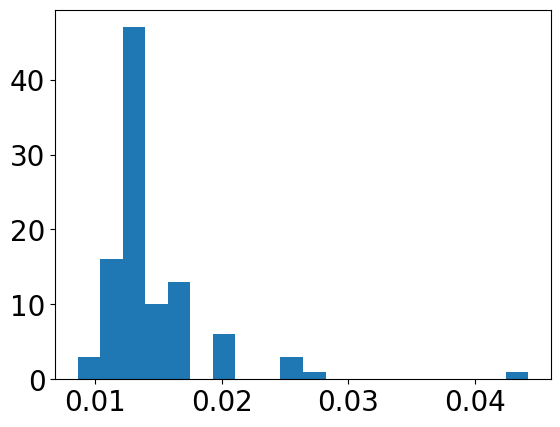

In [20]:
sigmas = []
for i in out1["nodes"]:
    sigmas += [i.params_node["scale"]]
plt.hist(sigmas, bins=20)

(-5.0, 5.0)

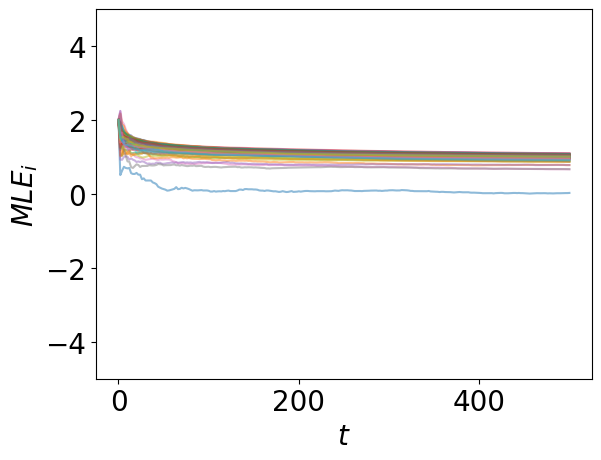

In [21]:
mu_arr = np.array(out1["mu_nodes"])
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
for i in range(len(mu_arr.T)):
    plt.plot(x, mu_arr.T[i], alpha=0.5, label=f"Node {i}")
    plt.xlabel("$t$")
    plt.ylabel("$MLE_i$")
plt.ylim(-5, 5)

#### Data analysis 2

In [22]:
N_iter = range(input["G"].number_of_nodes())
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
quad_dis = np.array(out1["p_distances"])[:, 1]
print(lin_dis.shape)
kld.shape
np.array(out1["p_distances"]).shape

(251, 100)


(251, 2, 100)

/tmp/ipykernel_45671/1446127089.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,2)


(251,)

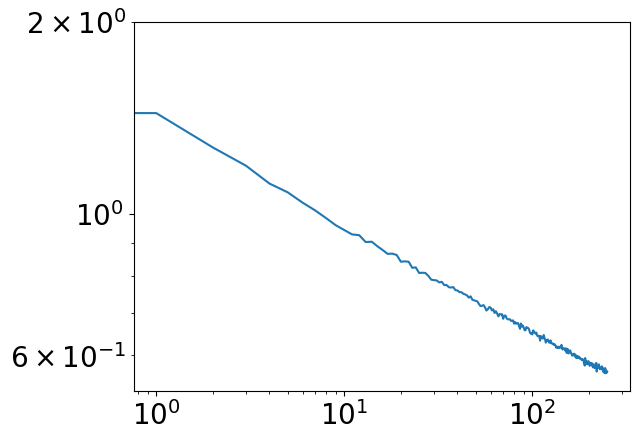

In [23]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])


i = 1
plt.plot(
    # input["t_sample"] * np.arange(0, kld.shape[0]),
    kld.mean(axis=i),
    label="avg",
)
plt.loglog()
plt.ylim(0, 2)

kld.mean(axis=i).shape

In [24]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, quad_dis.shape[0]), quad_dis[:, 0, i])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
for i in N_iter:
    plt.plot(input["t_sample"] * np.arange(0, lin_dis.shape[0]), lin_dis[:, 0, i])

In [ ]:
arr = np.array(out1["p_distances"])
print(arr.shape)
(arr[-1, 0, 1, :] ** 2).mean()

In [ ]:
arr2 = np.array(out1["kl_divs"])
arr2.shape
np.array(out1["mu_nodes"]).shape

In [ ]:
arr[:, 0].shape